# What Affects The Number of Positions?

We assume that the positions per day is affected by:
1) the density
2) the quality of the AIS device
3) the movments of the vessel

The movement of the vessel affects how frequently it will try to broadcast its location. Based on http://www.milltechmarine.com/faq.htm:

Class A:
 Ships Dynamic Conditions        | Dual Channel Receiver | Single Channel Receiver  
 Ship at anchor or moored        | 3 min                 | 6 min                    
 SOG 0-14 knots                  | 10 sec                | 20 sec                   
 SOG 0-14 knots, changing course | 3.3 sec               | 6.6 sec                  
 SOG 14-23 knots                 | 6 sec                 | 12 sec                   
 SOG 14-23 knots, changing course| 2 sec                 | 4 sec                    
 SOG >23 knots                   | 2 sec                 | 4 sec                    
 Ship Static Information         | 6 min                 | 12 min                  

Class B:    
Ships Dynamic Conditions        | Dual Channel Receiver | Single Channel Receiver
SOG < 2 knots                   | 3 min                 | 6 min                   
SOG > 2 knots                   | 10 sec                | 20 sec                   
Ship Static Information         | 6 min                 | 12 min                  


In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import cPickle # save the query results for later



In [ ]:
import bq  
client = bq.Client.Get()


In [3]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [4]:
q = '''
SELECT
  integer(FLOOR(a_first_lat*10)) lat_bin,
  integer(FLOOR(a_first_lon*10)) lon_bin,
  integer(FLOOR(a_avg_lat*10)) lat_bin_avg,
  integer(FLOOR(a_avg_lon*10)) lon_bin_avg,
  a_satellite_positions sat_positions,
  a_positions positions
FROM
  [scratch_david_gapanalysis.ave_locations_2015_with_density_v2]
WHERE
  a_date = "2015-01-01"
  AND a_max_lat - a_min_lat <5
  AND (a_max_lon - a_min_lon < 10
    OR a_first_lon > 170
    OR a_first_lon < -170)
  AND a_mmsi IN (select mmsi from
[scratch_david_gapanalysis.good_mmsi_2015_1000pings]
  )
'''

positions = Query(q)

Waiting on bqjob_r5864ef08fcc20010_000001533f476e97_1 ... (5s) Current status: DONE   
Query time: 32.011084795 seconds.


In [5]:
cPickle.dump(positions, open('../../data/density/20150101_vessels.p', 'wb')) 

In [4]:
positions = cPickle.load(open('../../data/density/20150101_vessels.p', 'rb'))

In [5]:
cellsize = 2
num_lons = 360/cellsize
num_lats = 180/cellsize

In [6]:
# first calculate a raster of vessel locations from the query

vessels = np.zeros(shape=(num_lats,num_lons)) 

for row in positions:
    lat = int(row[0])
    lon = int(row[1])
    if lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        vessels[lat_index][lon_index] += 1 # one vessel 


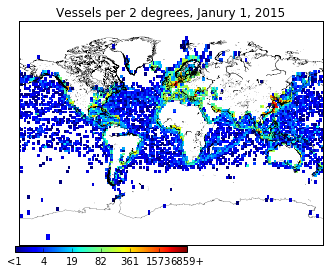

In [9]:
# map this density

firstlat = 90
lastlat = -90
firstlon = -180
lastlon = 180
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()

m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary()
m.drawcoastlines(linewidth=.2)
#m.fillcontinents('#555555')#, lake_color, ax, zorder, alpha)


x = np.linspace(-180, 180, 360/cellsize )
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)

from matplotlib import colors,colorbar
norm = colors.LogNorm(vmin=1, vmax=1000)
m3 = int(vessels.max()**.333) # set the max to the max of the scale

m.pcolormesh(converted_x, converted_y, vessels, norm=norm, vmin=1, vmax=m3**3)

t = "Vessels per 2 degrees, Janury 1, 2015"
plt.title(t)
ax = fig.add_axes([0.15, 0.1, 0.4, 0.02]) 
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(0,3,7)

cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls)
cb.ax.set_xticklabels(["<1" ,int(m3**.5), m3, int(m3**1.5), m3*m3,int(m3**2.5), str(int(m3**3))+"+"], fontsize=10)


#plt.savefig(".png",bbox_inches='tight',dpi=450,transparent=True,pad_inches=0)

plt.rcParams["figure.figsize"] = [12,8]
plt.show()

In [8]:
# create the density that is seen by satellites

def create_average_raster(filename):
    # load the file that helps with the satellite averaging
    grid_for_average = np.load(filename)
    avgs = np.zeros(shape=(num_lats,num_lons)) # 2 by 2 grid

    for i in range(num_lats):
        for j in range(num_lons):
            count = len(grid_for_average[i][j])
            total = 0
            for item in grid_for_average[i][j]:
                total += vessels[item[0]][item[1]]*item[2]
            avgs[i][j]=total/4. 
            # divide by 4 because the satellite sees only 1/4 of the area that we're 
            #averaging over
    return avgs


In [19]:
infile = '../../data/density/grid_for_average_2degree.npy'
averages = create_average_raster(infile)

In [9]:
infile = '../../data/density/grid_for_average_2degree_2000.npy'
averages_2000 = create_average_raster(infile)

In [ ]:
infile = '../../data/density/grid_for_average_2degree_1000.npy'
averages_1000 = create_average_raster(infile)

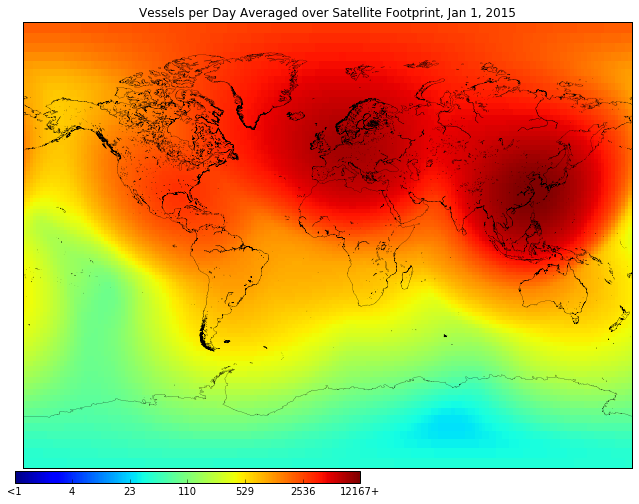

In [12]:
# map the vessel density seen by satellite

firstlat = 90
lastlat = -90
firstlon = -180
lastlon = 180
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
plt.clf()

m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary()
m.drawcoastlines(linewidth=.2)
#m.fillcontinents('#555555')# , lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360/cellsize )
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)

from matplotlib import colors,colorbar

norm = colors.LogNorm(vmin=1, vmax=1000)

m3 = int(averages.max()**.3333)

m.pcolormesh(converted_x, converted_y, averages, norm=norm, vmin=1, vmax=m3**3)

t = "Vessels per Day Averaged over Satellite Footprint, Jan 1, 2015"
plt.title(t)

ax = fig.add_axes([0.15, 0.1, 0.4, 0.02]) 
norm = colors.Normalize(vmin=0, vmax=1000)
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(0,3,7)

cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls)

cb.ax.set_xticklabels(["<1" ,int(m3**.5), m3, int(m3**1.5), m3*m3,int(m3**2.5), str(int(m3**3))+"+"], fontsize=10)


#plt.savefig("satellite_footprint2by2.png",bbox_inches='tight',dpi=450,transparent=True,pad_inches=0)

plt.rcParams["figure.figsize"] = [12,8]

plt.show()

In [20]:
# now make a chart of pings versus position

den = []
pos = []
count = 0
#averages = averages_2000
for row in positions:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = row[4]
    all_pos = row[5]
    count += 1
    # must only be satellite positions
    if sat_pos == all_pos and lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        den.append(averages[lat_index][lon_index])
        pos.append(int(sat_pos))

-0.786135200409 0.00970844087838 0.0


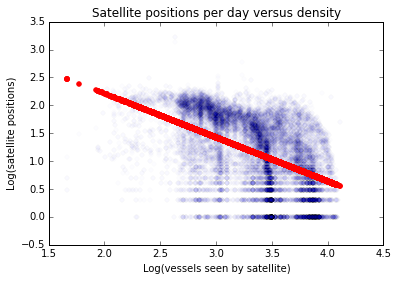

In [21]:
x = den
y = pos

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.set_yscale('log')
# ax.set_xscale('log')

plt.scatter(np.log10(x), np.log10(y), alpha=.01)#, color = color)
# plt.scatter(x1, y1, alpha=1)#, color = color)

logA = np.log10(x)
logB = np.log10(y)
coefficients = np.polyfit(logA, logB, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(np.log10(x))
slope, intercept, r_value, p_value, std_err = stats.linregress(logA, logB)

plt.scatter(np.log10(x), ys, color = 'red')


# print slope
# print coefficients
# print r_value
# print p_value
print slope,std_err,p_value

plt.title("Satellite positions per day versus density")
plt.xlabel('Log(vessels seen by satellite)')
plt.ylabel('Log(satellite positions)')

plt.show()

-0.00011942133819 1.56660255589e-06 0.0


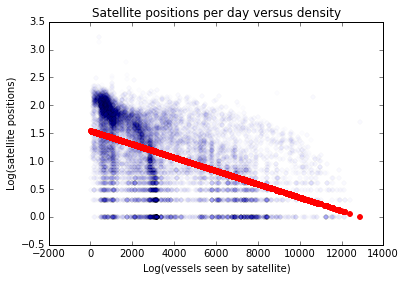

In [22]:
x = den
y = pos

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.set_yscale('log')
# ax.set_xscale('log')

plt.scatter(x, np.log10(y), alpha=.01)#, color = color)
# plt.scatter(x1, y1, alpha=1)#, color = color)

# logA = np.log10(x)
logB = np.log10(y)
coefficients = np.polyfit(x, logB, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(x)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, logB)

plt.scatter(x, ys, color = 'red')


# print slope
# print coefficients
# print r_value
# print p_value
print slope,std_err,p_value

plt.title("Satellite positions per day versus density")
plt.xlabel('Log(vessels seen by satellite)')
plt.ylabel('Log(satellite positions)')

plt.show()

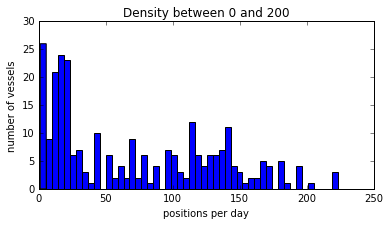

 Density between 0 and 200 :  12


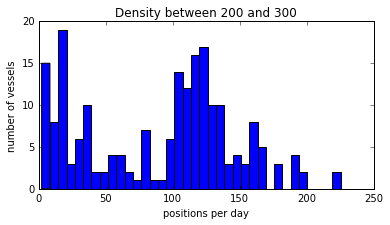

Density between 200 and 300 :  7


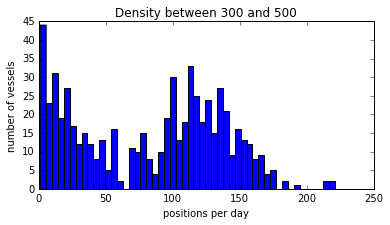

Density between 300 and 500 :  10


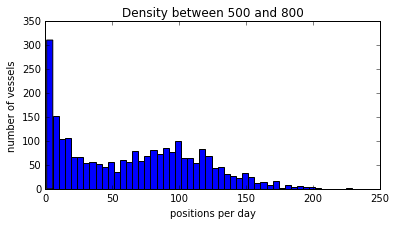

Density between 500 and 800 :  17


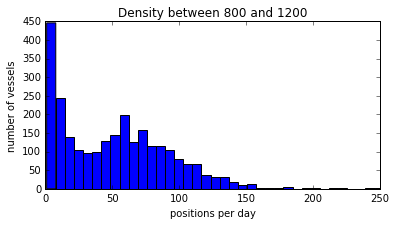

Density between 800 and 1200 :  19


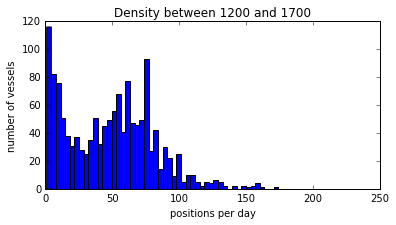

Density between 1200 and 1700 :  17


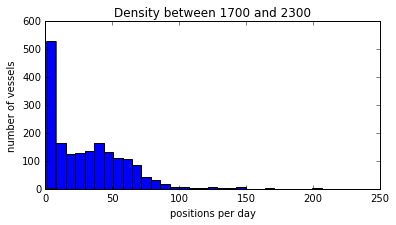

Density between 1700 and 2300 :  30


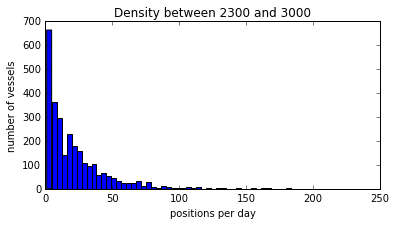

Density between 2300 and 3000 :  38


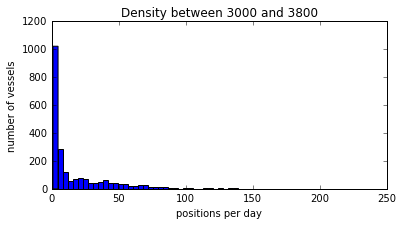

Density between 3000 and 3800 :  59


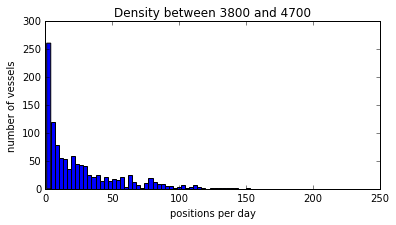

Density between 3800 and 4700 :  38


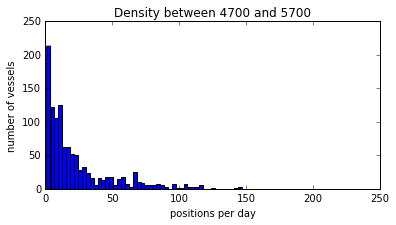

Density between 4700 and 5700 :  39


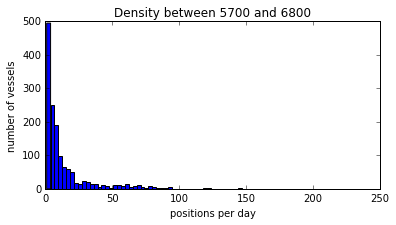

Density between 5700 and 6800 :  64


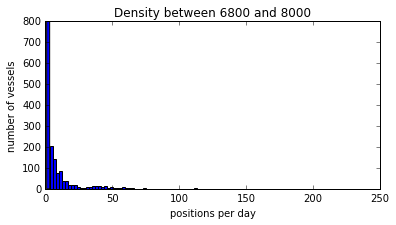

Density between 6800 and 8000 :  77


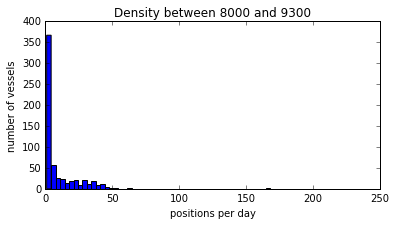

Density between 8000 and 9300 :  71


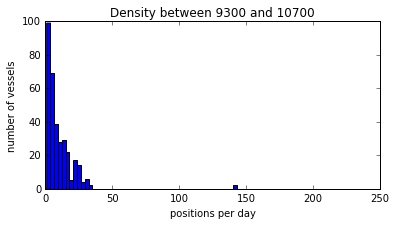

Density between 9300 and 10700 :  61


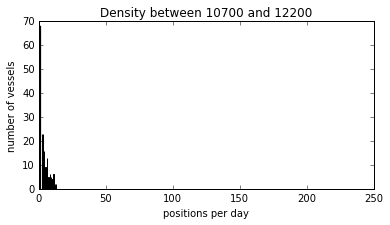

Density between 10700 and 12200 :  92


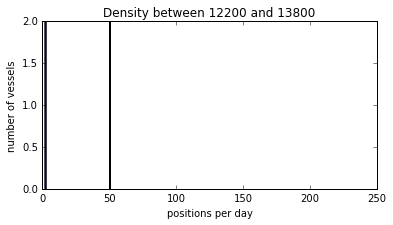

Density between 12200 and 13800 :  50


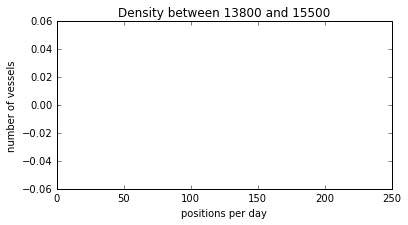

Density between 13800 and 15500 : 

ZeroDivisionError: integer division or modulo by zero

In [17]:
minimum = 0
maximum = 200
plt.rcParams["figure.figsize"] = [6,3]

for i in range(18):

    x = []

    plt.clf()
    if i > 0:
        minimum = maximum
    maximum += 100*i
    
    less_than_5 = 0
    count = 0
    for p, d in zip (pos, den):
        if d>minimum and d<maximum and p<400:
            x.append(p)
            if p<10:
                less_than_5 += 1
            count+=1
    plt.title("Density between "+str(minimum)+" and "+str(maximum))     
    plt.xlabel("positions per day")
    plt.ylabel("number of vessels")
    plt.hist(x, bins=50)
    plt.xlim([0,250])

    plt.show()
    print "Density between "+str(minimum)+" and "+str(maximum) + " : ", int(100*less_than_5/count)

In [13]:
# okay, let's look at only fishing vessels

q = '''
SELECT
  integer(FLOOR(a_first_lat*10)) lat_bin,
  integer(FLOOR(a_first_lon*10)) lon_bin,
  integer(FLOOR(a_avg_lat*10)) lat_bin_avg,
  integer(FLOOR(a_avg_lon*10)) lon_bin_avg,
  a_satellite_positions sat_positions,
  a_positions positions
FROM
  [scratch_david_gapanalysis.ave_locations_2015_with_density_v2]
WHERE
  a_date = "2015-01-01"
  AND a_max_lat - a_min_lat <5
  AND (a_max_lon - a_min_lon < 10
    OR a_first_lon > 170
    OR a_first_lon < -170)
  AND a_mmsi IN (select mmsi from
[scratch_david_mmsi_lists.Combinedfishing_2014]
  )
'''

positions_fishing_vessels = Query(q)


Waiting on bqjob_r6a16a99088a29707_000001530ad38aee_2 ... (7s) Current status: DONE   
Query time: 16.1007111073 seconds.


In [14]:
# now make a chart of pings versus position

den = []
pos = []
count = 0

for row in positions_fishing_vessels:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = row[4]
    all_pos = row[5]
    count += 1
    # must only be satellite positions
    if sat_pos == all_pos and lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        den.append(averages[lat_index][lon_index])
        pos.append(int(sat_pos))

-0.585306674036 0.0293862270318 3.75524846468e-79


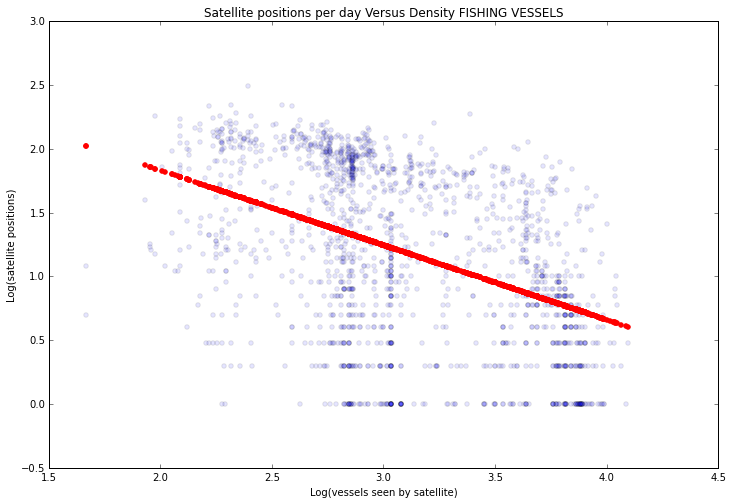

In [15]:
x = den
y = pos

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.set_yscale('log')
# ax.set_xscale('log')

plt.scatter(np.log10(x), np.log10(y), alpha=.1)#, color = color)
# plt.scatter(x1, y1, alpha=1)#, color = color)

logA = np.log10(x)
logB = np.log10(y)
coefficients = np.polyfit(logA, logB, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(np.log10(x))
slope, intercept, r_value, p_value, std_err = stats.linregress(logA, logB)

plt.scatter(np.log10(x), ys, color = 'red')


# print slope
# print coefficients
# print r_value
# print p_value
print slope,std_err,p_value

plt.title("Satellite positions per day Versus Density FISHING VESSELS")
plt.xlabel('Log(vessels seen by satellite)')
plt.ylabel('Log(satellite positions)')

plt.show()

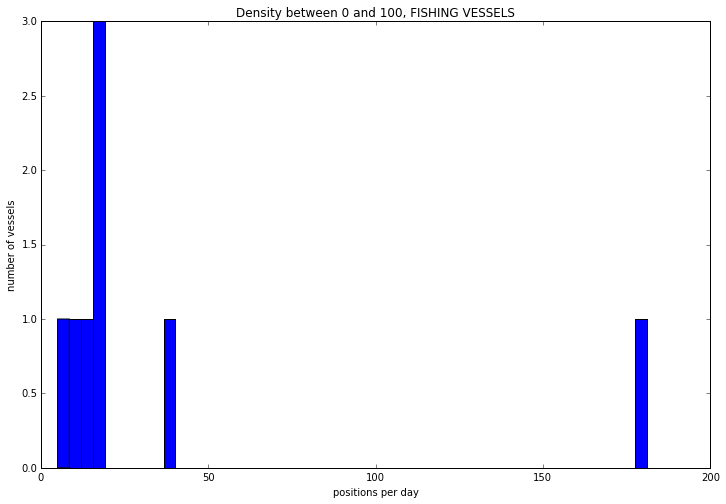

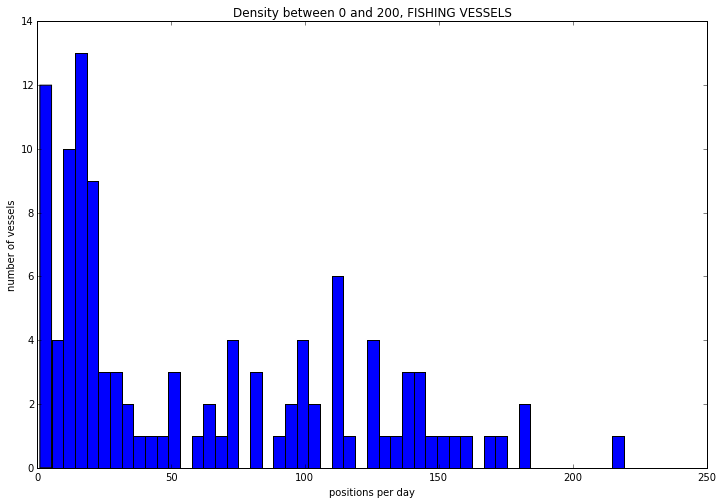

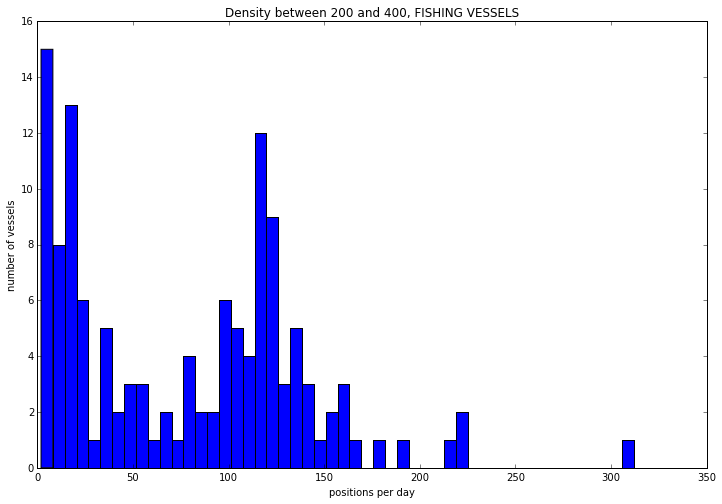

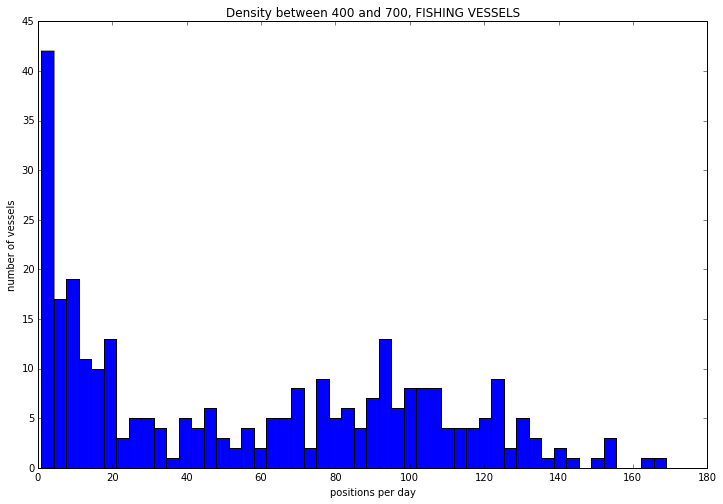

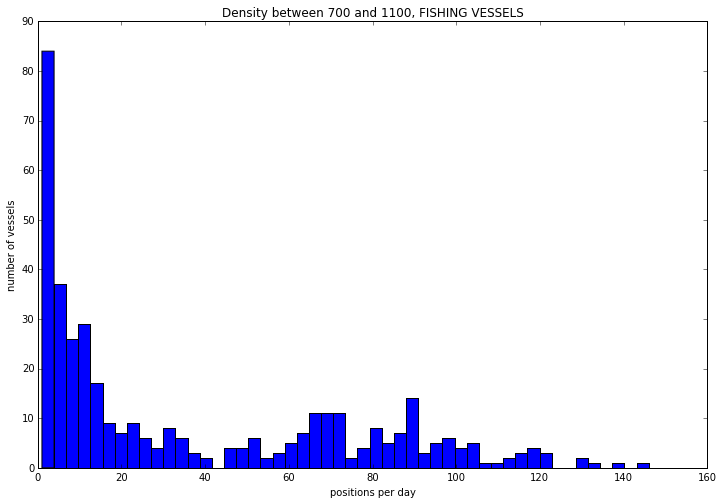

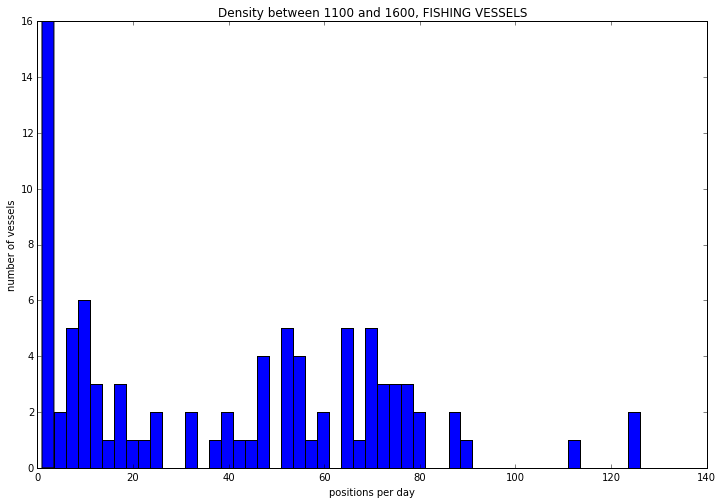

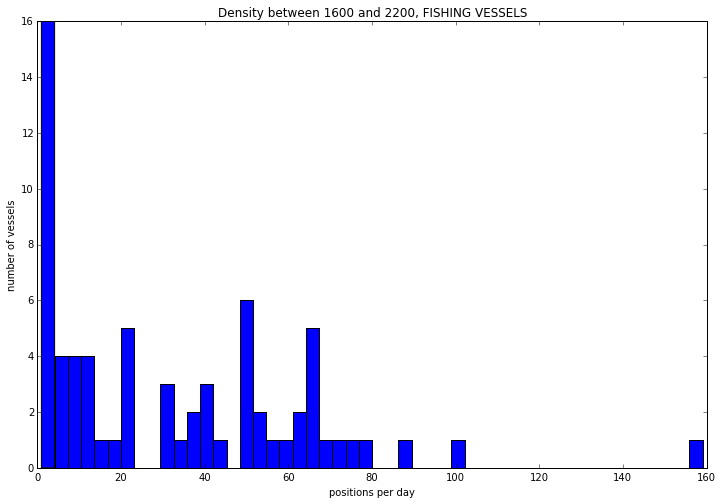

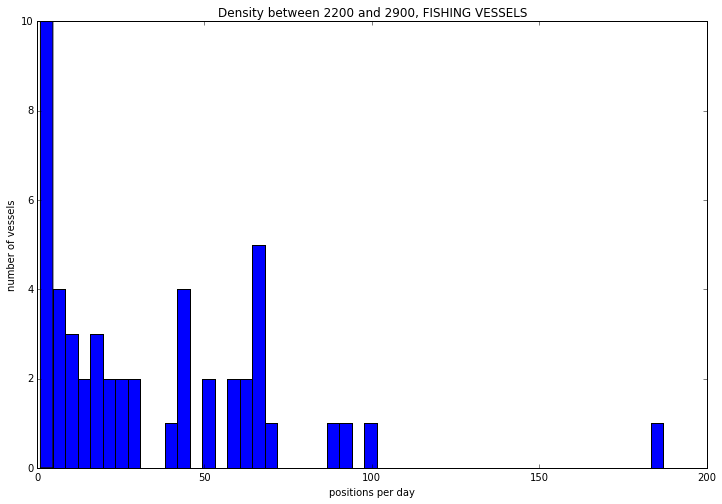

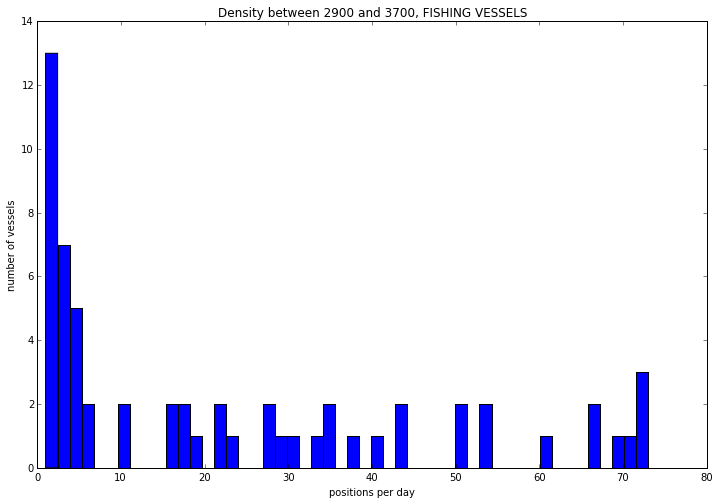

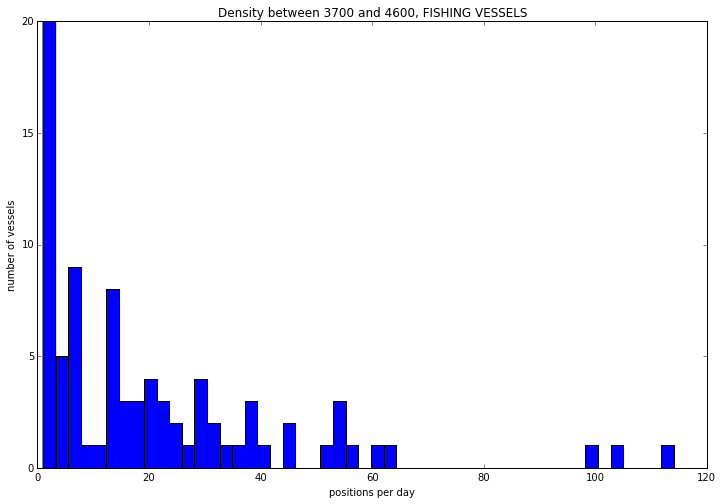

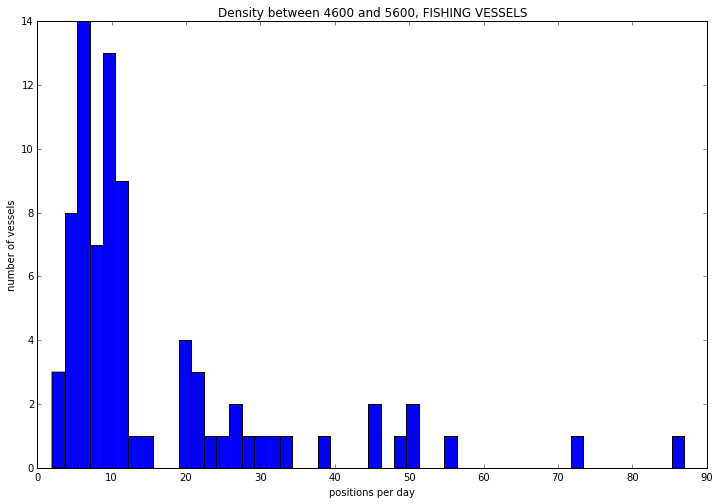

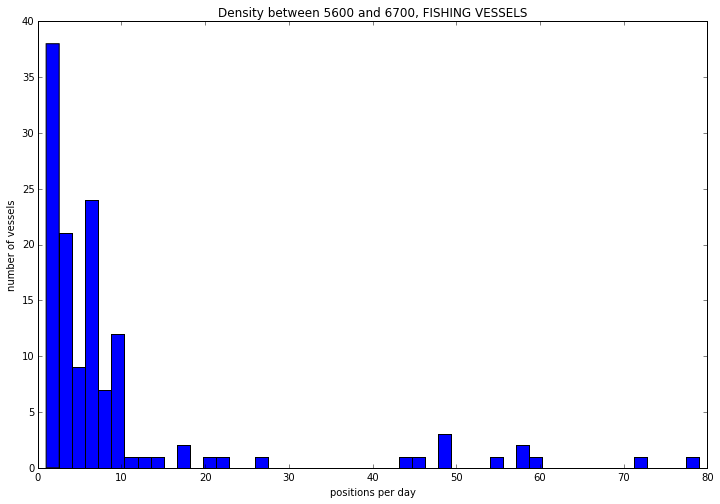

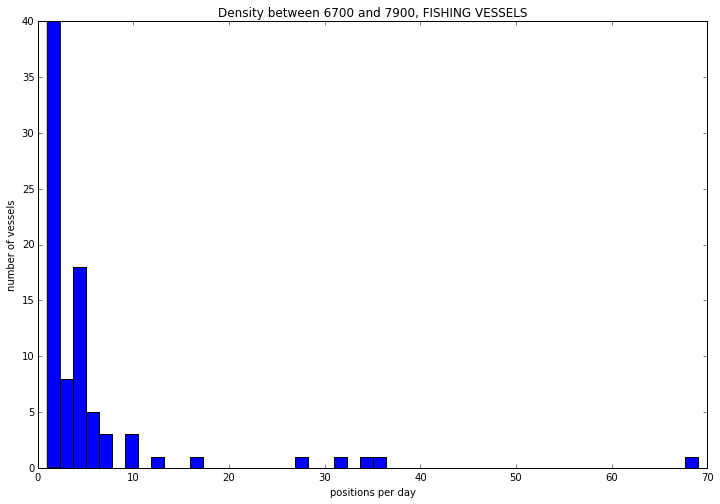

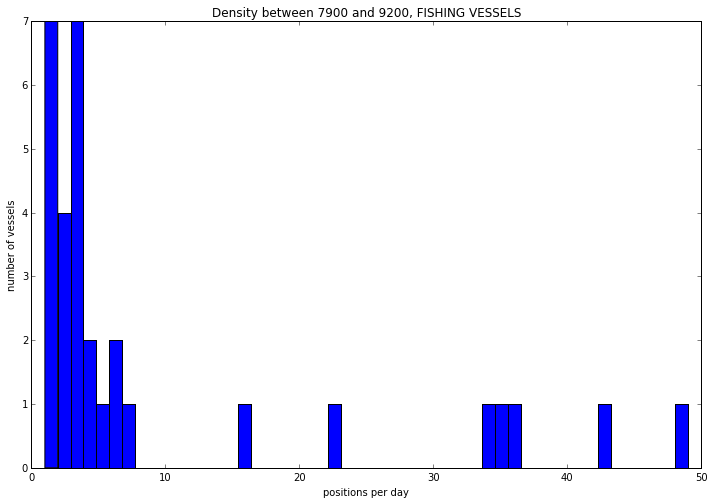

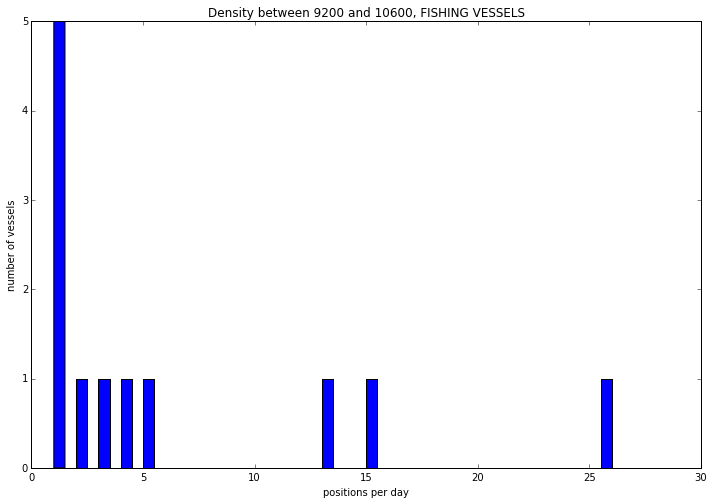

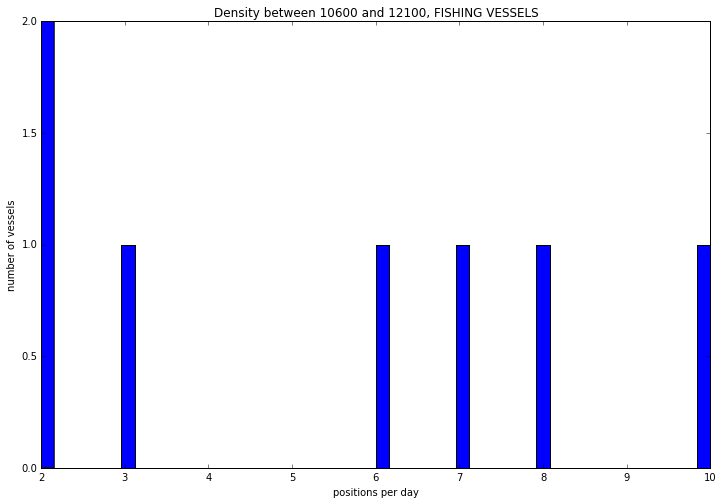

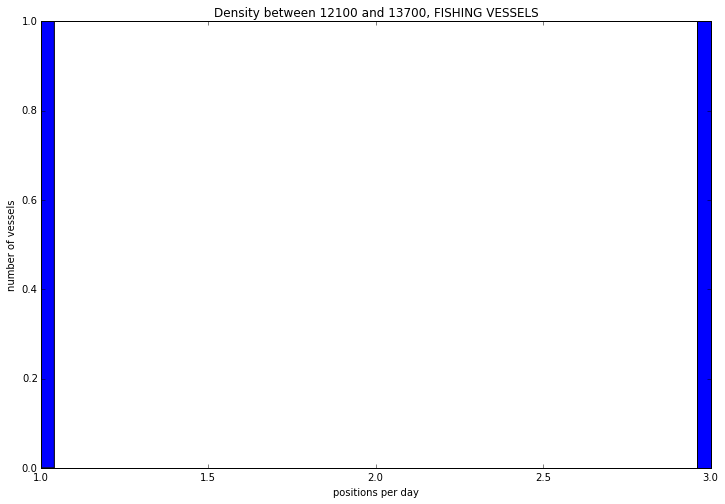

ValueError: x must have at least one data point

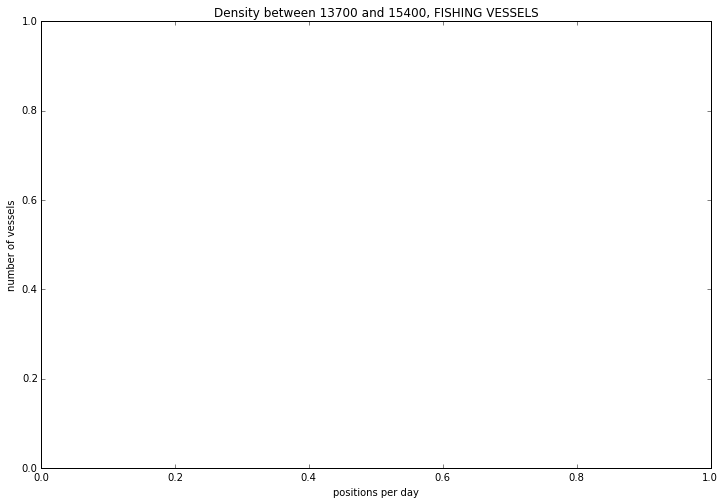

In [16]:
minimum = 0
maximum = 100

for i in range(18):

    x = []

    plt.clf()
    if i > 1:
        minimum = maximum
    maximum += 100*i

    for p, d in zip (pos, den):
        if d>minimum and d<maximum and p<400:
            x.append(p)
    plt.title("Density between "+str(minimum)+" and "+str(maximum)+", FISHING VESSELS")     
    plt.xlabel("positions per day")
    plt.ylabel("number of vessels")
    plt.hist(x, bins=50)
    plt.show()

In [ ]:
# okay, let's look at averages

q = '''
SELECT
  integer(FLOOR(a_avg_lat*10)) lat_bin_avg,
  integer(FLOOR(a_avg_lon*10)) lon_bin_avg,
  avg(a_satellite_positions) sat_positions,
  count(*)
  FROM
  [scratch_david_gapanalysis.ave_locations_2015_with_density_v2]
WHERE
  a_positions = a_satellite_positions
  and a_date = "2015-01-01"
  AND a_max_lat - a_min_lat <5
  AND (a_max_lon - a_min_lon < 10)
  AND a_mmsi IN (select mmsi from
[scratch_david_mmsi_lists.Combinedfishing_2014])
GROUP BY lat_bin_avg, lon_bin_avg
'''

positions_fishing_vessels_avgs = Query(q)


In [ ]:
# now make a chart of pings versus position

den = []
pos = []

for row in positions_fishing_vessels_avgs:
    lat = int(row[0])
    lon = int(row[1])
    sat_pos = row[2]
    number = int(row[3])
    # must only be satellite positions
    if lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        den.append(averages[lat_index][lon_index])
        pos.append(float(sat_pos))

In [ ]:
x = den
y = pos

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.set_yscale('log')
# ax.set_xscale('log')

plt.scatter(np.log10(x), np.log10(y), alpha=.1)#, color = color)
# plt.scatter(x1, y1, alpha=1)#, color = color)

logA = np.log10(x)
logB = np.log10(y)
coefficients = np.polyfit(logA, logB, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(np.log10(x))
slope, intercept, r_value, p_value, std_err = stats.linregress(logA, logB)

plt.scatter(np.log10(x), ys, color = 'red')


# print slope
# print coefficients
# print r_value
# print p_value
print slope,std_err,p_value

plt.title("AVERAGE Satellite positions per day Versus Density FISHING VESSELS")
plt.xlabel('Log(vessels seen by satellite)')
plt.ylabel('Log(satellite positions)')

plt.show()

1318